In [1]:
import librosa
import librosa.display
import os.path

from glob import glob
from IPython import display
from tqdm import tqdm_notebook as tqdm

Torch Modules

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from tensorboardX import SummaryWriter

In [2]:
from wavenet_vocoder.wavenet import WaveNet

In [3]:
get_spectrogram = lambda y: librosa.power_to_db(librosa.feature.melspectrogram(y, n_fft=num_fft,
                                                           hop_length=hop_length,
                                                           n_mels=num_mels,fmin=min_freq,
                                                           fmax=max_freq), ref=np.max).astype(np.float32) / 40 + 1

In [4]:
def plot_spectrogram(spectrogram):
    librosa.display.specshow(spectrogram * 40 - 40, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.title('Mel spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

In [22]:
use_gpu = True

In [5]:
num_mels = 80
sample_rate = 22.5 * 1e3

In [6]:
sample_rate = 24000
num_mels = 80
num_fft = int(50 * 1e-3 * sample_rate)
hop_length = int(12.5 * 1e-3 * sample_rate)
min_freq = 125
max_freq = 7.6 * 1e3

In [7]:
train_files = -1
val_split = 0.1

In [38]:
num_classes = 256

In [20]:
cuda = lambda x: x.cuda() if use_gpu and torch.cuda.is_available() else x

In [8]:
hear = lambda x: display.Audio(x, rate=sample_rate)

In [10]:
file_len = np.load(os.path.join(DIR_CHECKPOINTS, 'file_len.npy'))

In [11]:
filenames = sorted(glob('/home/vaisakh/.data/LJSpeech/wavs/*.wav'))

In [12]:
if train_files < 0: train_files = len(filenames)
filenames_train = filenames[:train_files]

In [13]:
val_idx = int((1 - val_split) * len(filenames_train))
filenames_val = filenames_train[val_idx:]

filenames_train = filenames_train[:val_idx]

del val_idx

In [14]:
sample_audio = librosa.load(filenames_train[0], sr=sample_rate)[0]

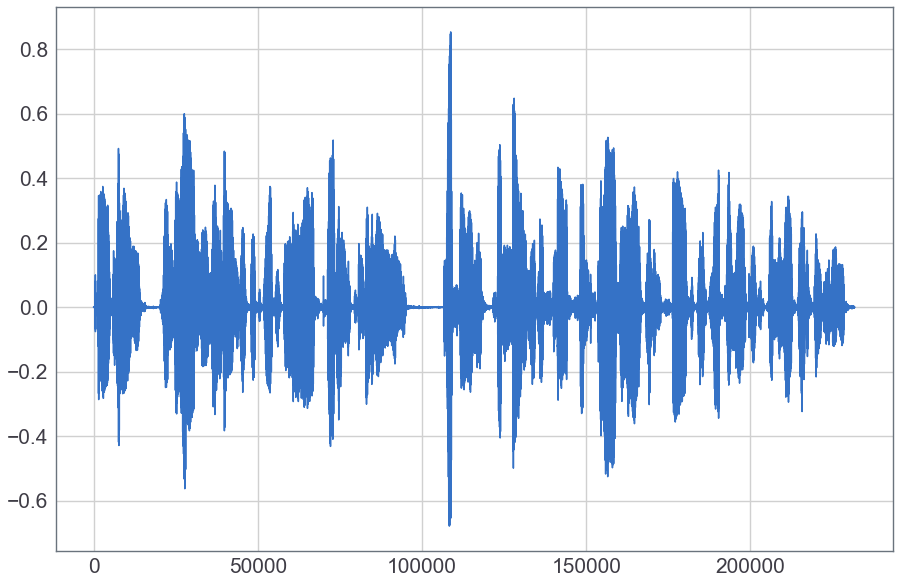

In [15]:
plot(sample_audio)
hear(sample_audio)

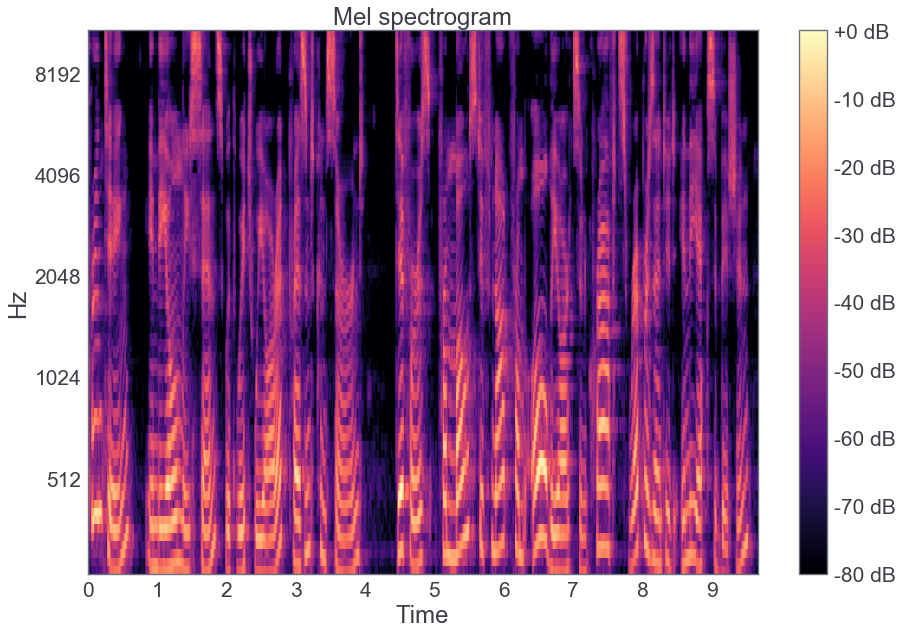

In [16]:
sample_spectrogram = get_spectrogram(sample_audio)

plot_spectrogram(sample_spectrogram)

In [94]:
def one_hot(x, num_classes):
    oh = torch.zeros(num_classes, len(x))
    return oh.scatter_(0, x.unsqueeze(0).long(), 1)

In [96]:
def data_generator(train=True, teacher_force=True):
    while True:
        if train:
            file_idx = np.random.randint(len(filenames_train))
            y = librosa.load(filenames_train[file_idx], sr=sample_rate)[0]
        else:
            file_idx = np.random.randint(len(filenames_val))
            y = librosa.load(filenames_val[file_idx], sr=sample_rate)[0]
        
        spectrogram = cuda(torch.from_numpy(get_spectrogram(y)))
        y = torch.from_numpy(y)
        
        spectrogram = torch.unsqueeze(spectrogram, 0)
        spectrogram = F.upsample(spectrogram, scale_factor=hop_length).data[:, :, :len(y)]
        
        y = torch.unsqueeze(one_hot(y, num_classes=num_classes), 0)
        
        y = Variable(cuda(y))
        spectrogram = Variable(spectrogram)
        if not teacher_force:
            y.volatile = True
            spectrogram.volatile = True
        
        yield y, spectrogram

In [97]:
next(data_generator())

(Variable containing:
 (  0   ,.,.) = 
    1   1   1  ...    1   1   1
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
      ...       ⋱       ...    
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
    0   0   0  ...    0   0   0
 [torch.cuda.FloatTensor of size 1x256x155652 (GPU 0)], Variable containing:
 (  0   ,.,.) = 
   1.0699e-01  1.0699e-01  1.0699e-01  ...  -6.4038e-01 -6.4038e-01 -6.4038e-01
   2.3004e-01  2.3004e-01  2.3004e-01  ...  -5.6126e-01 -5.6126e-01 -5.6126e-01
   1.8495e-01  1.8495e-01  1.8495e-01  ...  -3.1780e-01 -3.1780e-01 -3.1780e-01
                  ...                   ⋱                   ...                
  -4.1335e-01 -4.1335e-01 -4.1335e-01  ...  -8.2018e-01 -8.2018e-01 -8.2018e-01
  -5.6167e-01 -5.6167e-01 -5.6167e-01  ...  -9.1658e-01 -9.1658e-01 -9.1658e-01
  -4.6876e-01 -4.6876e-01 -4.6876e-01  ...  -8.5269e-01 -8.5269e-01 -8.5269e-01
 [torch.cuda.FloatTensor of size 1x80x155652 (GPU 0)])

In [34]:
wavenet = cuda(WaveNet(layers=12, cin_channels=num_mels))

In [98]:
wavenet(*next(data_generator()))

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518243271935/work/torch/lib/THC/generic/THCStorage.cu:58